In [1]:
import pandas as pd
import numpy as np
from mxnet import gpu
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler


from gluonts.dataset.field_names import FieldName
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from gluonts.mx.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.mx.trainer import Trainer

from gluonts.model.predictor import Predictor
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    SetFieldIfNotPresent,
)

# predictor_deserialized = Predictor.deserialize(Path("/tmp/"))

%load_ext autoreload
%autoreload 2

In [2]:
# 预测新增的确诊、死亡、康复
confirmed = pd.read_csv('raw_data/COVID/time_series_covid19_confirmed_global.csv')
# 拿2019年的indicators
indicators = pd.read_excel('raw_data/SUSTAIN database_08Jan2021_Asia and Latin America.xlsx')
policy = pd.read_excel('raw_data/SUSTAIN database_09Jan2021_policies_Asia and Latin America.xlsx')

In [3]:
# confirmed.head(10)
# len(list(set(policy.entity)))
# len(list(set(indicators.Country)))
# len(list(set(confirmed['Country/Region'])))
countries = list(set(policy.entity).intersection(set(confirmed['Country/Region'])).intersection(set(indicators['Country'])))

In [130]:
confirmed_series = confirmed.groupby('Country/Region').sum().drop(['Lat', 'Long'],axis=1).loc[countries, :].T[countries]
target = StandardScaler().fit_transform(confirmed_series).T

In [131]:
confirmed_series

Country/Region,Indonesia,Singapore,Laos,Haiti,Argentina,Nepal,Guatemala,Belize,Chile,Panama,...,Ecuador,Honduras,India,Malaysia,Uruguay,Peru,Bolivia,Thailand,Venezuela,China
1/22/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,548
1/23/20,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,643
1/24/20,0,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5,0,920
1/25/20,0,3,0,0,0,1,0,0,0,0,...,0,0,0,3,0,0,0,7,0,1406
1/26/20,0,4,0,0,0,1,0,0,0,0,...,0,0,0,4,0,0,0,8,0,2075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/22/20,678125,58461,41,9771,1555279,255236,133601,10257,589189,217202,...,206364,117588,10099066,97389,14001,998475,151059,5716,110828,95228
12/23/20,685639,58482,41,9805,1563865,255979,134256,10370,590914,220261,...,207084,118036,10123778,98737,14710,1000153,152064,5762,111024,95298
12/24/20,692838,58495,41,9805,1563865,256592,134894,10490,594152,223674,...,208010,118036,10146845,100318,15457,1000153,153121,5910,111245,95383
12/25/20,700097,58509,41,9805,1574554,257200,135080,10490,595831,226660,...,208828,118659,10169118,101565,15848,1003982,153590,6020,111603,95460


In [127]:
indicators.pivot()

,Theme,Indicator,ISO,Country,Unit,Source,1990,1991,1992,1993,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Baseline/Communications,Fixed broadband subscriptions,AFG,Afghanistan,number,WB - International Telecommunication Union (IT...,NaN,NaN,NaN,NaN,...,1.500000e+03,1.500000e+03,1.500000e+03,1.500000e+03,7.067000e+03,8.801000e+03,1.681000e+04,1.749100e+04,1.968300e+04,NaN
1,Baseline/Communications,Fixed broadband subscriptions,AFG,Afghanistan,per 100 people,WB - International Telecommunication Union (IT...,NaN,NaN,NaN,NaN,...,5.139540e-03,4.813650e-03,4.648340e-03,4.494950e-03,2.053550e-02,2.487350e-02,4.631350e-02,4.705430e-02,5.174050e-02,NaN
2,Baseline/Communications,Fixed broadband subscriptions,ARG,Argentina,number,WB - International Telecommunication Union (IT...,NaN,NaN,NaN,NaN,...,4.572020e+06,5.148580e+06,6.251020e+06,6.519460e+06,6.855840e+06,7.223130e+06,7.842780e+06,8.473660e+06,8.793180e+06,NaN
3,Baseline/Communications,Fixed broadband subscriptions,ARG,Argentina,per 100 people,WB - International Telecommunication Union (IT...,NaN,NaN,NaN,NaN,...,1.106480e+01,1.233040e+01,1.481420e+01,1.529040e+01,1.591590e+01,1.660170e+01,1.785000e+01,1.910150e+01,1.963610e+01,NaN
4,Baseline/Communications,Fixed broadband subscriptions,BGD,Bangladesh,number,WB - International Telecommunication Union (IT...,NaN,NaN,NaN,NaN,...,4.685000e+05,6.004610e+05,1.525330e+06,3.093170e+06,4.892940e+06,6.592400e+06,7.300500e+06,1.022110e+07,8.085500e+06,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10511,Social and political,Women who believe a husband is justified in be...,SUR,Suriname,proportion,World Development Indicators,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10512,Social and political,Women who believe a husband is justified in be...,THA,Thailand,proportion,World Development Indicators,NaN,NaN,NaN,NaN,...,NaN,1.310000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10513,Social and political,Women who believe a husband is justified in be...,URY,Uruguay,proportion,World Development Indicators,NaN,NaN,NaN,NaN,...,NaN,NaN,1.500000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10514,Social and political,Women who believe a husband is justified in be...,VEN,Venezuela,proportion,World Development Indicators,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# target = confirmed_series.values.T

In [7]:
covariate_d = np.zeros(target.shape)#np.concatenate((target, target), axis=0)
covariate_d.shape
covariate_d = target

In [8]:
target.shape

(41, 340)

In [9]:
covariate_s = [[0] for _ in range(target.shape[0])]
# covariate_s

In [10]:
# define the parameters of the dataset
custom_ds_metadata = {'num_series': len(countries),
                      'num_steps': len(confirmed_series),
                      'prediction_length': 10,
                      'context_length': 10,
                      'freq': '1D',
                      'start': [pd.Timestamp(confirmed_series.index[0], freq='1D')
                                for _ in range(len(confirmed_series))]
                     }

"""
    START = "start"
    TARGET = "target"

    FEAT_STATIC_CAT = "feat_static_cat"
    FEAT_STATIC_REAL = "feat_static_real"
    FEAT_DYNAMIC_CAT = "feat_dynamic_cat"
    FEAT_DYNAMIC_REAL = "feat_dynamic_real"
    PAST_FEAT_DYNAMIC_REAL = "past_feat_dynamic_real"
    FEAT_DYNAMIC_REAL_LEGACY = "dynamic_feat"

    FEAT_DYNAMIC = "feat_dynamic"
    PAST_FEAT_DYNAMIC = "past_feat_dynamic"

    FEAT_DYNAMIC = "feat_dynamic"

    FEAT_TIME = "time_feat"
    FEAT_CONST = "feat_dynamic_const"
    FEAT_AGE = "feat_dynamic_age"

    OBSERVED_VALUES = "observed_values"
    IS_PAD = "is_pad"
    FORECAST_START = "forecast_start"

    TARGET_DIM_INDICATOR = "target_dimension_indicator"
"""

'\n    START = "start"\n    TARGET = "target"\n\n    FEAT_STATIC_CAT = "feat_static_cat"\n    FEAT_STATIC_REAL = "feat_static_real"\n    FEAT_DYNAMIC_CAT = "feat_dynamic_cat"\n    FEAT_DYNAMIC_REAL = "feat_dynamic_real"\n    PAST_FEAT_DYNAMIC_REAL = "past_feat_dynamic_real"\n    FEAT_DYNAMIC_REAL_LEGACY = "dynamic_feat"\n\n    FEAT_DYNAMIC = "feat_dynamic"\n    PAST_FEAT_DYNAMIC = "past_feat_dynamic"\n\n    FEAT_DYNAMIC = "feat_dynamic"\n\n    FEAT_TIME = "time_feat"\n    FEAT_CONST = "feat_dynamic_const"\n    FEAT_AGE = "feat_dynamic_age"\n\n    OBSERVED_VALUES = "observed_values"\n    IS_PAD = "is_pad"\n    FORECAST_START = "forecast_start"\n\n    TARGET_DIM_INDICATOR = "target_dimension_indicator"\n'

In [11]:
train_ds = ListDataset([{FieldName.TARGET: target,
                         FieldName.START: start,
                         FieldName.FEAT_STATIC_REAL: fsr,
                         FieldName.FEAT_DYNAMIC_REAL: [fdr],
#                          FieldName.FEAT_STATIC_CAT: fsc
                        }
                        for (target, start, fsr, fdr) in zip(target[:, :-custom_ds_metadata['prediction_length']],
                                                             custom_ds_metadata['start'],
                                                             covariate_s,
                                                             covariate_d[:, :-custom_ds_metadata['prediction_length']],
#                                                              feat_static_cat
                                                            )],
                      freq=custom_ds_metadata['freq'])

test_ds = ListDataset([{FieldName.TARGET: target,
                        FieldName.START: start,
                        FieldName.FEAT_STATIC_REAL: fsr,
                        FieldName.FEAT_DYNAMIC_REAL: [fdr],
#                          FieldName.FEAT_STATIC_CAT: fsc
                       }
                       for (target, start, fsr, fdr) in zip(target,
                                                  custom_ds_metadata['start'],
                                                  covariate_s,
                                                  covariate_d,
#                                                             feat_static_cat
                                                      )],
                     freq=custom_ds_metadata['freq'])

In [ ]:
next(iter(train_ds))

In [ ]:
# test_series = to_pandas(test_entry)
# train_series = to_pandas(train_entry)

# fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

# train_series.plot(ax=ax[0])
# ax[0].grid(which="both")
# ax[0].legend(["train series"], loc="upper left")

# test_series.plot(ax=ax[1])
# ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
# ax[1].grid(which="both")
# ax[1].legend(["test series", "end of train series"], loc="upper left")

# plt.show()

In [120]:
# from gluonts.model.deepar import DeepAREstimator
from gluonts.model.n_beats import NBEATSEstimator
from gluonts.model.transformer import TransformerEstimator
from gluonts.model.seq2seq import MQRNNEstimator, MQCNNEstimator
from gluonts.mx.distribution import StudentTOutput
from gluonts.mx.distribution import GaussianOutput,UniformOutput,NegativeBinomialOutput

# from model.my_deepar import DeepAREstimator
# estimator = DeepAREstimator(
# #     num_layers=1,
# #     num_cells=40,
# #     distr_output = NegativeBinomialOutput(),
# #     alpha=0.5,
# #     beta=0.5,
#     prediction_length=custom_ds_metadata['prediction_length'],
# #     context_length=custom_ds_metadata['context_length'],
#     freq=custom_ds_metadata['freq'],
#     use_feat_dynamic_real=True,
# #     use_feat_static_real=True,
# #     use_feat_static_cat=True,
# #     cardinality=cat_cardinality,
# #     lags_seq=[1],
#     trainer=Trainer(ctx="cpu",#gpu(0),
#                     epochs=10,
#                     learning_rate=1e-3,
#                     num_batches_per_epoch=100,
#                     batch_size=32,
#                    )
# )


# from model.simple_feedforward import SimpleFeedForwardEstimator
# estimator = SimpleFeedForwardEstimator(
# #     sampling=False,
#     num_hidden_dimensions=[40],
#     distr_output = StudentTOutput(),
#     prediction_length=custom_ds_metadata['prediction_length'],
#     context_length=custom_ds_metadata['prediction_length'],
#     freq=custom_ds_metadata['freq'],
#     trainer=Trainer(ctx="cpu",#gpu(0),
#                     epochs=10,
#                     learning_rate=1e-3,
#                     num_batches_per_epoch=100,
#                     batch_size=32,
#                    )
# )

from model.my_network import MyProbEstimator
estimator = MyProbEstimator(
    prediction_length=custom_ds_metadata['prediction_length'],
    context_length=custom_ds_metadata['context_length'],
    freq=custom_ds_metadata['freq'],
    distr_output = StudentTOutput(),
    num_cells=[10, 10, 64],
    scaling=True,
    trainer=Trainer(ctx="cpu",#gpu(0),
                    epochs=10,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100,
                    batch_size=32,
                    hybridize=False, 
                   )
)

In [121]:
predictor = estimator.train(train_ds)

  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 100/100 [00:01<00:00, 74.55it/s, epoch=10/10, avg_epoch_loss=-1.65]


In [122]:
# predictor.serialize(Path("/tmp/"))
# help(make_evaluation_predictions)


In [123]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [124]:
tss = list(ts_it)
# sampling
forecasts = list(forecast_it)

# distribution
# forecasts = [np.array(x.distribution.mean.asnumpy()) for x in list(forecast_it)]

In [125]:
country_index = 1
ts_entry = tss[country_index]
forecast_entry = forecasts[country_index]

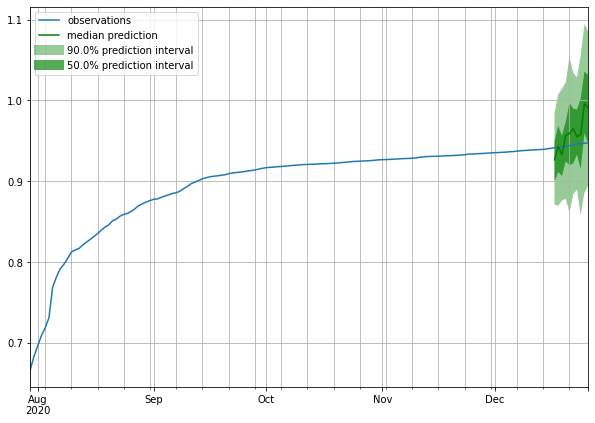

In [126]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

plot_prob_forecasts(ts_entry, forecast_entry)

In [ ]:
np.array(ts_entry[:5]).reshape(-1,)

In [ ]:
test_ds_entry = next(iter(test_ds))

In [ ]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

In [ ]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

In [ ]:
from gluonts.evaluation import Evaluator
import json

In [ ]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

In [ ]:
print(json.dumps(agg_metrics, indent=4))

In [ ]:
item_metrics.head()

In [ ]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()